In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.optimize import minimize
from scipy.optimize import least_squares

In [2]:
from scipy.misc import derivative

In [3]:
with open("data.pkl", "rb") as handle:
    data = pkl.load(handle).T

## Problem 1

Plot the best fit lines and uncertainty ellipses implied by the covariance matrix for problem 1 and 2 from the first homework.

In [4]:
x_data = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165,
          201, 157, 131,  166, 160, 186, 125, 218, 146])
y_data = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442,
          317, 311, 400, 337, 423, 334, 533, 344])
sigma_y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34,
           31, 42, 26, 16, 22])

In [5]:
'Only consider data points 6-20'
x = x_data[5:]
y = y_data[5:]
sig = sigma_y[5:]

In [6]:
Y = y
A = np.array([np.ones(len(x)),x]) #this is really A transpose because of the way numpy works
C_in = np.diagflat(1/(sig)**2) 

In [7]:
X = np.linalg.inv((A@C_in)@A.T)@((A@C_in)@Y)

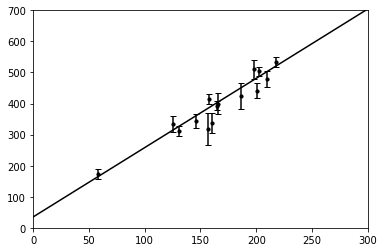

In [8]:
x_axis = np.linspace(0,300)
fit = X[1]*x_axis+X[0]

fig, ax = plt.subplots()
ax.scatter(x,y,10,'k')
ax.errorbar( x, y, yerr = sig, fmt = 'None', ecolor = 'k', capsize= 3)
ax.plot(x_axis,fit,'k',2)
plt.xlim([0,300])
plt.ylim([0,700])
ax.grid(which = 'minor')



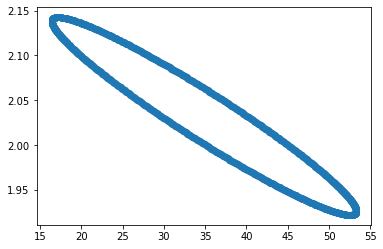

In [9]:
Co = np.linalg.inv((A@C_in)@A.T)
b,m = X[0],X[1]
eig = np.linalg.eig(Co)
theta = np.linspace(0,2*np.pi,1000)
ellipse = [np.column_stack(eig[1]).T@np.array([np.cos(t)*np.sqrt(eig[0][0])+b,np.sin(t)*np.sqrt(eig[0][1])+m]) for t in theta]
plt.scatter(*zip(*ellipse))

In [10]:
x = x_data
y = y_data
sig = sigma_y

In [11]:
Y = y
A = np.array([np.ones(len(x)),x]) #this is really A transpose because of the way numpy works
C_in = np.diagflat(1/(sig)**2) 

In [12]:
X = np.linalg.inv((A@C_in)@A.T)@((A@C_in)@Y)

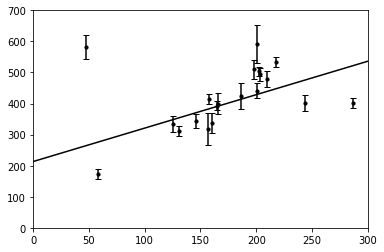

In [13]:
x_axis = np.linspace(0,300)
fit = X[1]*x_axis+X[0]

fig, ax = plt.subplots()
ax.scatter(x,y,10,'k')
ax.errorbar( x, y, yerr = sig, fmt = 'None', ecolor = 'k', capsize= 3)
ax.plot(x_axis,fit,'k',2)
plt.xlim([0,300])
plt.ylim([0,700])
ax.grid(which = 'minor')

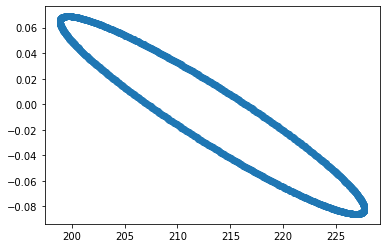

In [14]:
Co = np.linalg.inv((A@C_in)@A.T)
b,m = X[0],X[1]
eig = np.linalg.eig(Co)
theta = np.linspace(0,2*np.pi,1000)
ellipse = [np.column_stack(eig[1]).T@np.array([np.cos(t)*np.sqrt(eig[0][0])+b,np.sin(t)*np.sqrt(eig[0][1])+m]) for t in theta]
plt.scatter(*zip(*ellipse))

Note how the inclusion of the "outlier" data so affects the range of aallowed slopes. The 1-sigma ellipse allows for even a negatively sloped best fit line.

## Problem 2

Find the standard uncertainty of the period of the second signal of signal 11 in HW2 by profiling out all of the other parameters.

In [15]:
def model(P,x):
    return P[0]*np.sin((2*np.pi/100)*x)+P[1]*np.cos((2*np.pi/100)*x)+P[2]+ P[3]*np.sin((2*np.pi/P[4])*x)+P[5]*np.cos((2*np.pi/P[4])*x)

In [16]:
def fun(P,x,y,C_in):
    return (model(P, x) - y)@C_in@(model(P, x) - y).T

In [17]:
x = data[0]
y = data[-1]
C_in = np.diagflat(1/data[1]**2)
arglist = ()
x0 = [4,2,2,0.01,200,1]
res = least_squares(fun, x0, bounds=(0, 500), args = (x,y,C_in))
res.x

array([2.31252804e+00, 2.05420978e+00, 2.87050489e-02, 1.29522484e-01,
       1.93327590e+02, 1.07652299e-03])

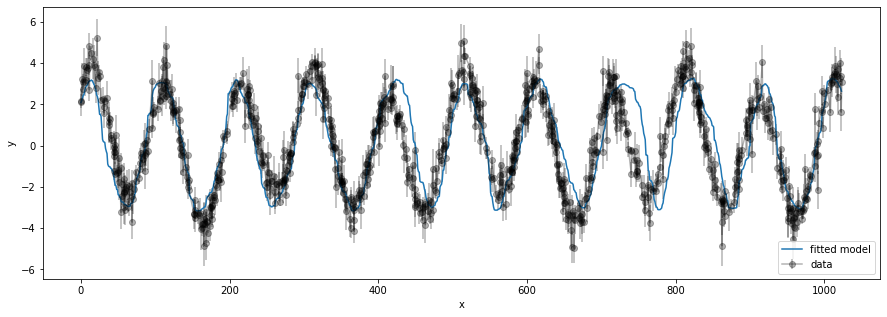

In [18]:
x_test = np.linspace(0,1023,1024)
y_test = model(res.x,data[0])
y = data[-1]
plt.figure(figsize=(15, 5))
plt.errorbar(x, y, yerr = data[1], marker = 'o', color = 'k', alpha = 0.3, label='data')
plt.plot(x_test, y_test, label='fitted model')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

In [19]:
periods = np.linspace(res.x[4]-.2,res.x[4]+.2,100)
proflik = np.array([fun([2.312,2.054,.0287,.1295,i,.00107],x,y,C_in) for i in periods])

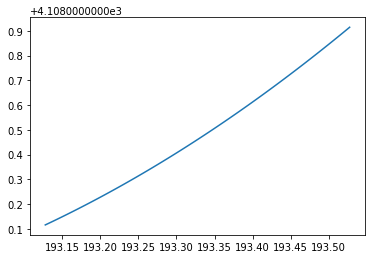

In [20]:
plt.plot(periods,proflik)

In [21]:
sec = np.gradient(np.gradient(proflik,.002),.002)
sigma_t = 1/np.mean(sec)**0.5
sigma_t

0.30191705243632905

The standar uncertainty of the second period is about 0.3.

## Problem 3

Write an MH MCMC.

In [22]:
def gaussian(x, mu, sig):
    return (sig*np.sqrt(2*np.pi))**-1*np.exp(-np.power(x - mu, 2.) / (2 *  np.power(sig, 2.)))

In [23]:
def p(x):
    return gaussian(x,2,np.sqrt(2))

In [24]:
def q(x,y):
    return gaussian(x,y,1)

In [25]:
def MH(n):
    ct = 0
    accepts = []
    x0 = 0
    while ct <= n:
        x = np.random.normal(x0,1)
        r = np.random.uniform()
        if p(x)/p(x0) > r:
            x0 = x
            accepts.append(x)
            ct+=1
    return accepts

In [26]:
hist = MH(0.5*10**5)

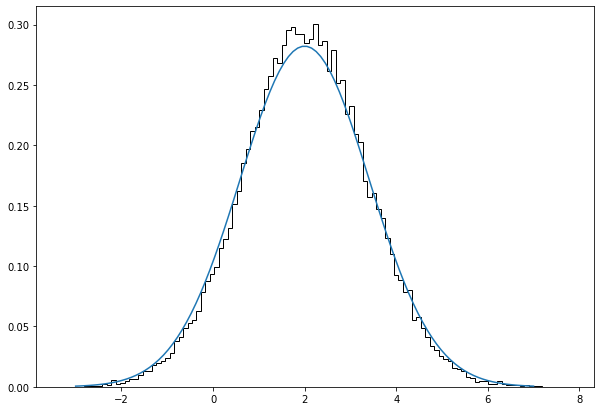

In [27]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(hist, bins = 'auto', histtype = 'step', color = 'k', density = True)
x = np.linspace(-3,7,100)
plt.plot(x,p(x))
plt.show()

## Problem 4

Do similarly as above but for the multivariate case.

In [33]:
def multigauss(x,mu,sig):
    sig_in = np.linalg.inv(sig)
    expon = -1/2*(x-mu)@sig_in@(x-mu).T
    det_sig = np.linalg.det(sig)
    return (1/(2*np.pi))*(det_sig**(-0.5))*np.exp(expon)

In [34]:
def p_2(x):
    return multigauss(x,np.array([0,0]),np.array([[2,1.2],[1.2,2]]))

In [35]:
def MH_multi(n):
    ct = 0
    accepts = []
    x0 = np.array([0,0])
    while ct <= n:
        x = np.random.multivariate_normal(x0,np.array([[1,0],[0,1]]))
        r = np.random.uniform()
        if p_2(x)/p_2(x0) > r:
            x0 = x
            accepts.append(x)
            ct+=1
    return accepts

In [36]:
points = MH_multi(10**4)

In [37]:
xpoints = np.array([l[0] for l in points])
ypoints = np.array([l[1] for l in points])

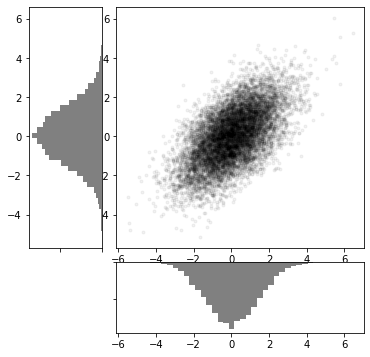

In [38]:
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(*zip(*points), 'ok', markersize=3, alpha=0.05)

# histogram on the attached axes
x_hist.hist(xpoints, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(ypoints, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

Now do the same but use the uniform distribution as your proposal distribution.

In [39]:
def p_f(x):
    c = 0
    if (x[0]>3 and x[0]<7) and (x[1]>1 and x[1]<9):
        c=1
    return c

In [40]:
def MH_multi_flat(n):
    ct = 0
    accepts = []
    x0 = np.array([4,2])
    while ct <= n:
        x = np.random.multivariate_normal(x0,np.array([[1,0],[0,1]]))
        r = np.random.uniform()
        if p_f(x)/p_f(x0) > r:
            x0 = x
            accepts.append(x)
            ct+=1
    return accepts

In [47]:
flats = MH_multi_flat(10**4)

In [48]:
xpoints = np.array([l[0] for l in flats])
ypoints = np.array([l[1] for l in flats])

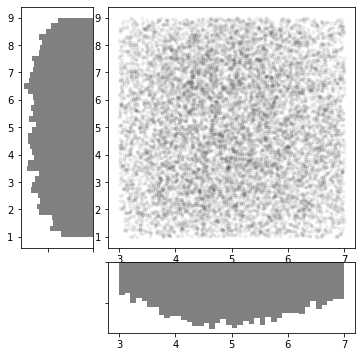

In [49]:
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(*zip(*flats), 'ok', markersize=3, alpha=0.05)

# histogram on the attached axes
x_hist.hist(xpoints, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(ypoints, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

## Problem 5

 Re-do Problem 2 but now look at convergence: Plot the x chain as a function of timestep. Also split the chain into four contiguous segments (the first, second, third, and fourth quarters of the chain). In each of these four, compute the empirical mean and empirical variance of x. What do you conclude about convergence from these heuristics?

In [50]:
exes = MH(10**4)

In [54]:
ns = np.arange(10**4+1)

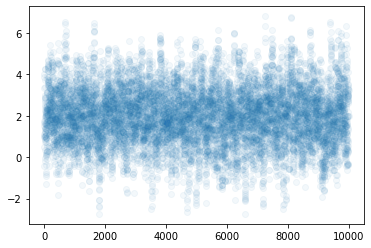

In [60]:
plt.scatter(ns,exes,alpha = 0.05)

In [61]:
first_q = np.array([exes[i] for i in range(2500)])

In [62]:
sec_q =  np.array([exes[i] for i in range(2500,5000)])

In [63]:
third_q =  np.array([exes[i] for i in range(5000,7500)])

In [64]:
fourth_q = np.array([exes[i] for i in range(7500,10000)])

In [68]:
np.mean(first_q),np.var(first_q)

(2.033140883228025, 1.7018030900770504)

In [69]:
np.mean(sec_q),np.var(sec_q)

(2.0041966970072402, 1.8378092266289037)

In [70]:
np.mean(third_q),np.var(third_q)

(1.9211261684378471, 2.003245180785154)

In [71]:
np.mean(fourth_q),np.var(fourth_q)

(1.982901275460406, 2.0374932469476517)

You can conclude from this that the mean converges faster than the variance. This makes sense since your mean will only be affected by pulling points symmetrically about the mean but the variance will require more points to establish.